# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_3m_0f_240214_1"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [40, 1870]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 73800
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,420.028611,77.605534,423.094210,78.588833,0.0,469.000000,28.000000,0.462745,491.000000,103.000000,-1.510700,11674.0,167.546256,97.138019,0.814781,3
1,1,0,1118.337084,990.032178,1118.645302,988.109130,NaN,1118.337084,990.032178,NaN,1118.337084,990.032178,0.951667,10131.0,153.816184,99.780474,0.761045,3
2,2,0,1653.930417,961.651564,1643.979723,961.366501,NaN,1653.930417,961.651564,NaN,1653.930417,961.651564,-1.312880,15406.0,215.544289,96.629397,0.893881,3
3,0,3,422.991475,76.499503,427.473575,76.898430,0.0,454.000000,25.000000,0.486275,346.000000,94.000000,-1.463450,12082.0,183.773084,98.064733,0.845725,3
4,1,3,1095.888973,976.237135,1093.085004,973.029138,0.0,1009.000000,883.000000,0.650980,985.000000,890.000000,0.998304,13195.0,239.934108,94.135339,0.919821,3
5,2,3,1654.007984,961.685707,1644.116726,961.372204,0.0,1654.000000,908.000000,0.533333,1592.000000,1007.000000,-1.311958,15406.0,215.241517,96.801010,0.893164,3


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([1, 2, 3])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        -tracking_0["orientation"].values[0],
        -tracking_0["orientation"].values[1],
        -tracking_0["orientation"].values[2]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x  position_y  orientation
0   0     0         3   420.028611   77.605534    -1.510700
1   1     0         3  1118.337084  990.032178     0.951667
2   2     0         3  1653.930417  961.651564    -1.312880


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,420.028611,77.605534,423.094210,78.588833,0.0,469.000000,28.000000,0.462745,491.000000,103.000000,-1.510700,11674.0,167.546256,97.138019,0.814781,3
1,1,0,1118.337084,990.032178,1118.645302,988.109130,NaN,1118.337084,990.032178,NaN,1118.337084,990.032178,0.951667,10131.0,153.816184,99.780474,0.761045,3
2,2,0,1653.930417,961.651564,1643.979723,961.366501,NaN,1653.930417,961.651564,NaN,1653.930417,961.651564,-1.312880,15406.0,215.544289,96.629397,0.893881,3
3,0,3,422.991475,76.499503,427.473575,76.898430,0.0,454.000000,25.000000,0.486275,346.000000,94.000000,-1.463450,12082.0,183.773084,98.064733,0.845725,3
4,1,3,1095.888973,976.237135,1093.085004,973.029138,0.0,1009.000000,883.000000,0.650980,985.000000,890.000000,0.998304,13195.0,239.934108,94.135339,0.919821,3
5,2,3,1654.007984,961.685707,1644.116726,961.372204,0.0,1654.000000,908.000000,0.533333,1592.000000,1007.000000,-1.311958,15406.0,215.241517,96.801010,0.893164,3
6,0,6,423.111277,76.460908,427.620982,76.849639,0.0,454.000000,25.000000,0.486275,428.000000,97.000000,-1.463571,12087.0,183.970949,98.029256,0.846209,3


In [7]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
18281,0,73797,1490.953177,85.392069,1478.560636,90.331142,NaN,1490.953177,85.392069,NaN,1490.953177,85.392069,-1.285105,10465.0,229.923372,77.244056,0.941878,5
18282,1,73797,1770.342682,487.643104,1771.502633,488.517739,NaN,1770.342682,487.643104,NaN,1770.342682,487.643104,0.203129,2603.0,96.030915,53.291388,0.831890,5
18283,2,73797,1726.094310,545.272019,1726.103971,545.193955,0.0,1738.000000,491.000000,0.266667,1735.000000,497.000000,-0.263416,1283.0,107.661458,17.529104,0.986656,5
18284,3,73797,1752.350353,631.150012,1751.129329,634.447283,NaN,1752.350353,631.150012,NaN,1752.350353,631.150012,-0.491401,4113.0,152.283285,42.968121,0.959368,5
18285,4,73797,1708.757589,952.882556,1702.061423,959.154484,0.0,1796.000000,838.000000,0.368627,1768.000000,857.000000,-0.700043,11035.0,273.229718,80.376724,0.955752,5


## Velocities distribution in each frame

In [8]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


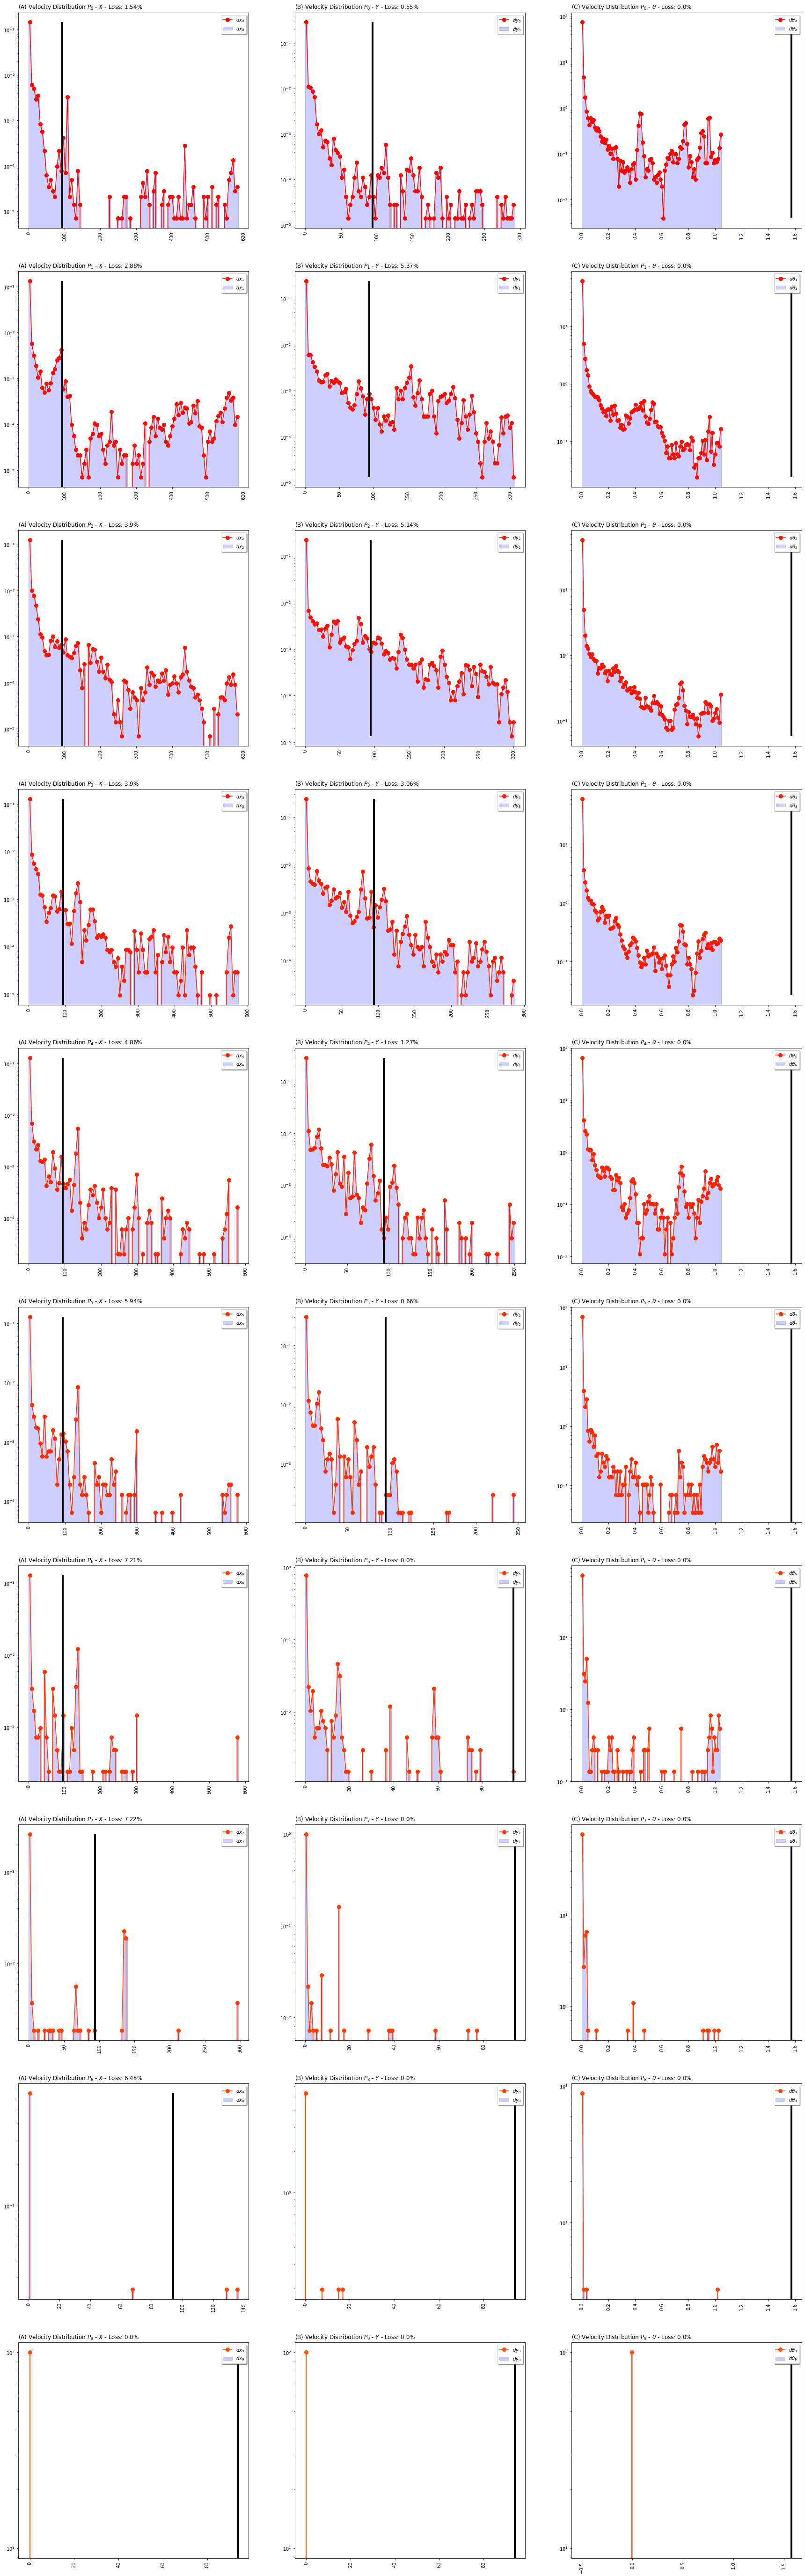

In [9]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [10]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,2,22
1,3,19563
2,4,37872
3,5,29285
4,6,12216
5,7,3689
6,8,1192
7,9,261
8,10,20


## Clustering frames

In [11]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 45.25902688142103 



In [12]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [13]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,0.018248
1,2,False,True,False,0.002881
2,3,False,False,False,17.364579
3,3,False,True,False,1.181329
4,3,True,False,False,0.131579
5,3,True,True,False,0.111410
6,4,False,False,False,34.409335
7,4,False,True,False,1.050711
8,4,True,False,False,0.719362
9,4,True,True,False,0.194007


In [14]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 11.42798710459125 
	- Angle: 45.25902688142103 



In [15]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 0.002710063822003008%
Final loss data X-axis: 2.3021992167915553%
Final loss data Y-axis: 1.8577487499830623%
Final loss data Angle : 1.6870147291968727%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,2,True,True,True,0.002710
1,3,False,False,False,0.036586
2,3,False,False,True,0.463421
3,3,False,True,False,0.182929
4,3,False,True,True,1.619263
5,3,True,False,False,0.014905
6,3,True,False,True,1.342837
7,3,True,True,False,1.452594
8,3,True,True,True,94.884755


In [16]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 11.42798710459125 
	- Angle: 45.25902688142103 



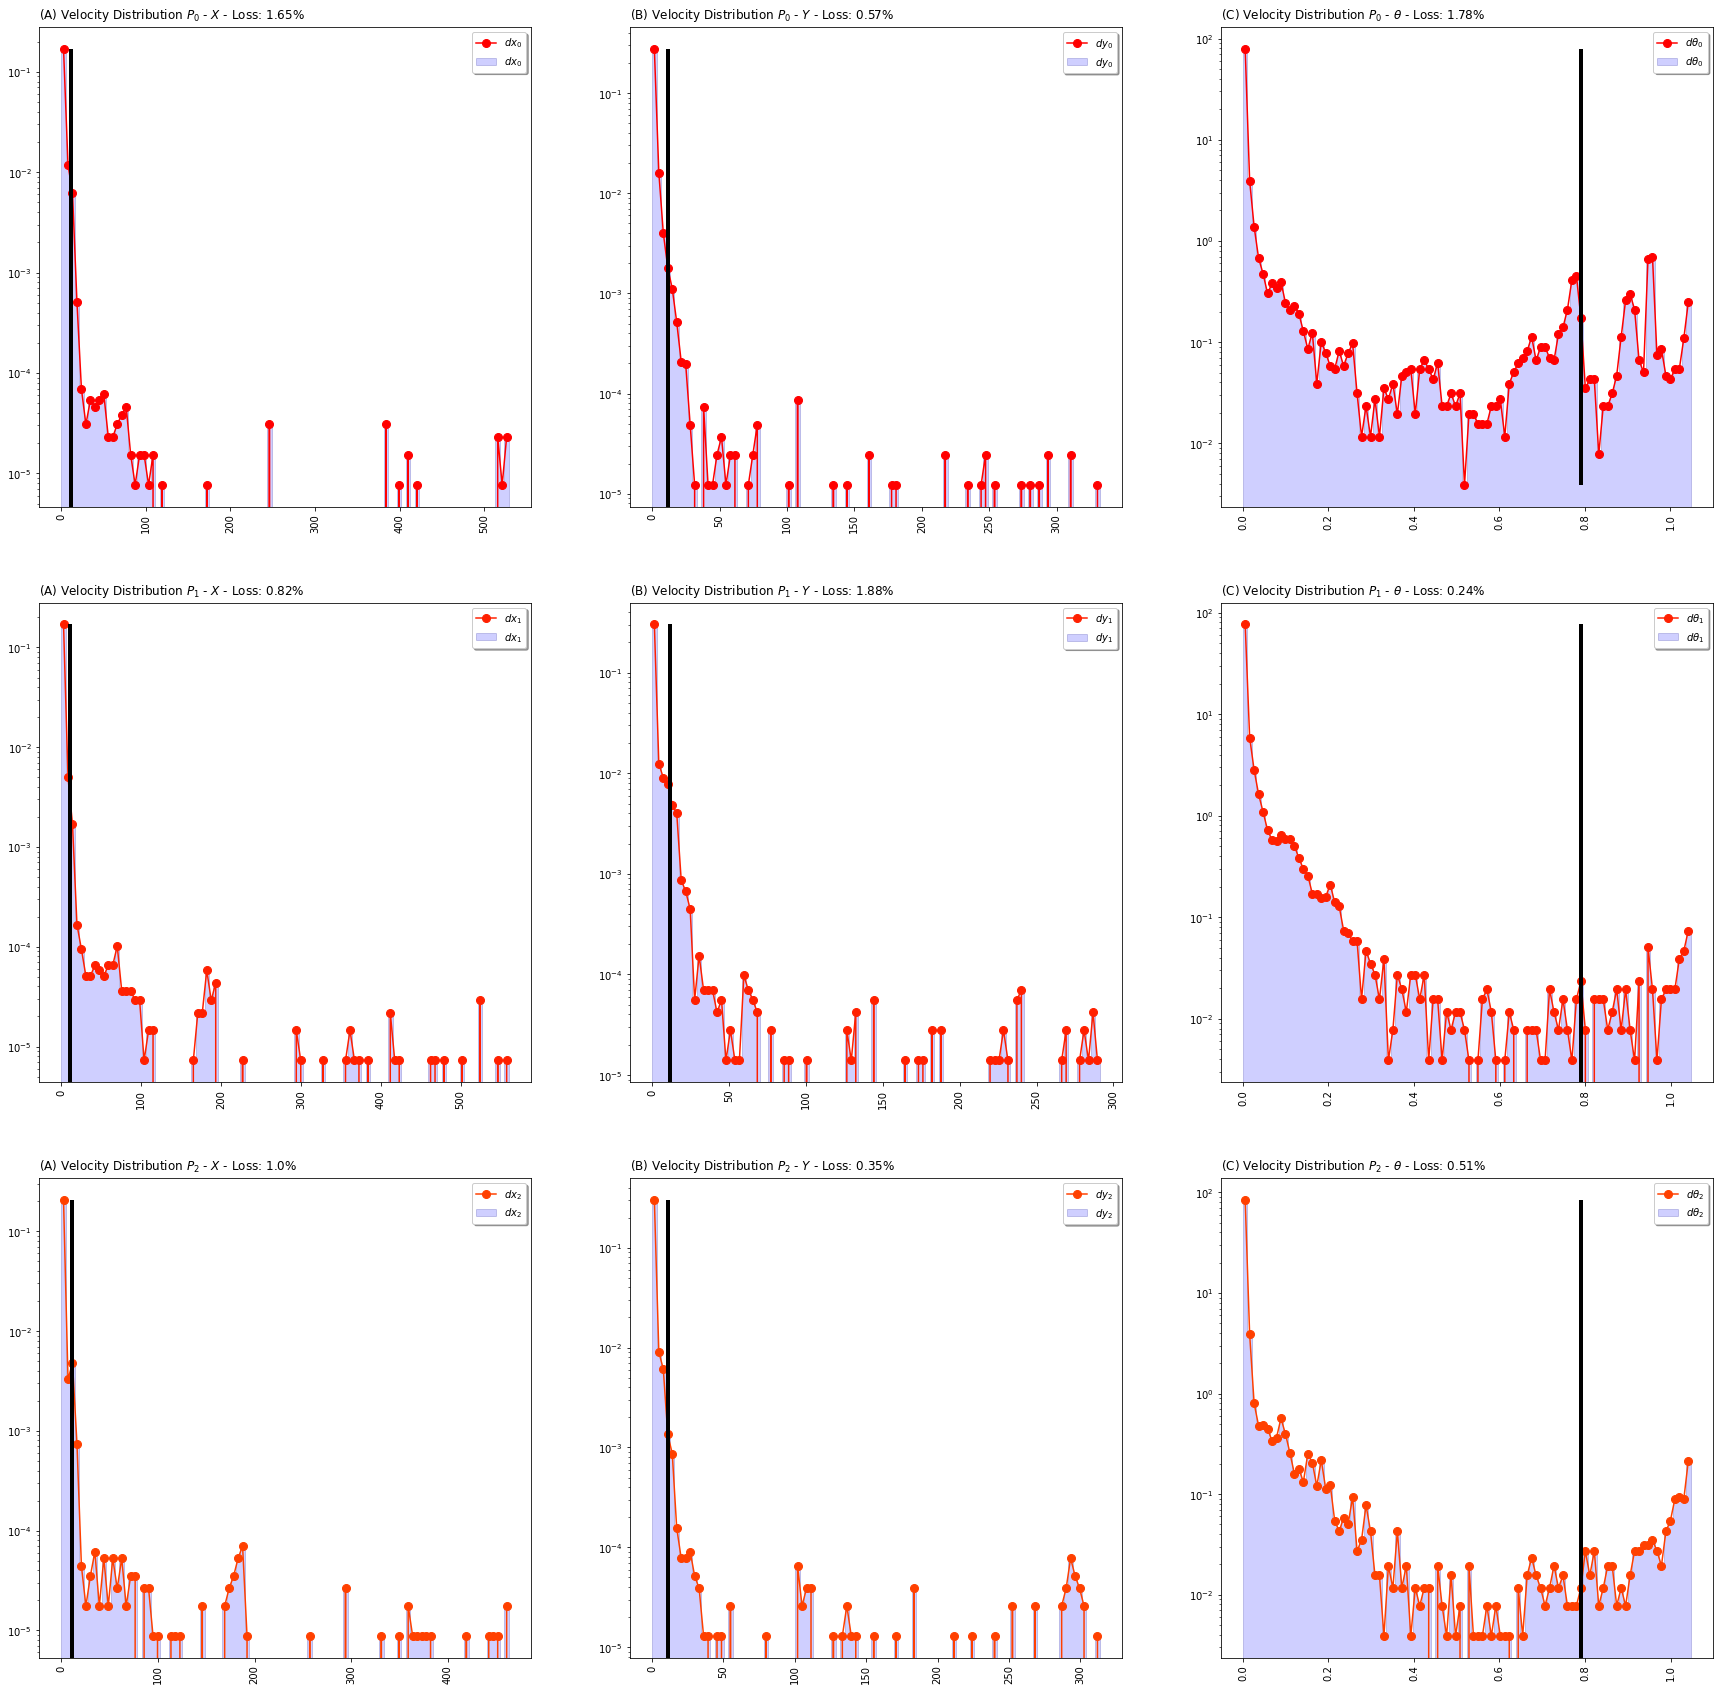

In [17]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [18]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [19]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,420.028611,77.605534,423.094210,78.588833,0.0,469.000000,28.000000,0.462745,491.000000,103.000000,-1.510700,11674.0,167.546256,97.138019,0.814781,3,NaN,NaN,NaN,NaN,False,False,False
6520,1,0,1118.337084,990.032178,1118.645302,988.109130,NaN,1118.337084,990.032178,NaN,1118.337084,990.032178,0.951667,10131.0,153.816184,99.780474,0.761045,3,NaN,NaN,NaN,NaN,False,False,False
13041,2,0,1653.930417,961.651564,1643.979723,961.366501,NaN,1653.930417,961.651564,NaN,1653.930417,961.651564,-1.312880,15406.0,215.544289,96.629397,0.893881,3,NaN,NaN,NaN,NaN,False,False,False
1,0,3,422.991475,76.499503,427.473575,76.898430,0.0,454.000000,25.000000,0.486275,346.000000,94.000000,-1.463450,12082.0,183.773084,98.064733,0.845725,3,3.0,0.987621,-0.368677,0.015750,False,False,False
6521,1,3,1095.888973,976.237135,1093.085004,973.029138,0.0,1009.000000,883.000000,0.650980,985.000000,890.000000,0.998304,13195.0,239.934108,94.135339,0.919821,3,3.0,-7.482704,-4.598348,0.015545,False,False,False
13042,2,3,1654.007984,961.685707,1644.116726,961.372204,0.0,1654.000000,908.000000,0.533333,1592.000000,1007.000000,-1.311958,15406.0,215.241517,96.801010,0.893164,3,3.0,0.025856,0.011381,0.000307,False,False,False
2,0,6,423.111277,76.460908,427.620982,76.849639,0.0,454.000000,25.000000,0.486275,428.000000,97.000000,-1.463571,12087.0,183.970949,98.029256,0.846209,3,3.0,0.039934,-0.012865,-0.000040,False,False,False
6522,1,6,1096.905540,977.171473,1094.386816,974.258394,NaN,1096.905540,977.171473,NaN,1096.905540,977.171473,1.002439,12725.0,239.658465,95.563464,0.917060,3,3.0,0.338856,0.311446,0.001378,False,False,False
13043,2,6,1655.493646,961.513385,1646.728814,961.059988,NaN,1655.493646,961.513385,NaN,1655.493646,961.513385,-1.314789,15503.0,215.819681,97.359299,0.892466,3,3.0,0.495221,-0.057441,-0.000943,False,False,False


## Visualize final data

In [20]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


In [21]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_3m_0f_240214_1_c.zip'